In [1]:
import numpy as np
import cv2
from pathlib import Path
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from descriptor_index_pb2 import DescriptorIndex
from debug_fusion_pb2 import DebugFusion
from utils import plot_imgs
%load_ext autoreload
%autoreload 2

INDEX_ROOT = '../deep-relocalization/data/'
MAP_ROOT = '../deep-relocalization/maps/'

In [2]:
def get_index(name):
    index = DescriptorIndex()
    with open(Path(INDEX_ROOT, name).as_posix(), 'rb') as f:
        index.ParseFromString(f.read())
    return index
def get_debug_data(name):
    debug = DebugFusion()
    with open(Path(INDEX_ROOT, 'loc_debug', name).as_posix(), 'rb') as f:
        debug.ParseFromString(f.read())
    return debug
def get_data_from_index(index):
    positions = np.stack([f.position_vector.data for f in index.frames])
    rotations = np.stack([np.reshape(f.rotation_matrix.data, (3, 3), order='C') for f in index.frames])
    descriptors = np.stack([f.global_descriptor.data for f in index.frames])
    resources = np.stack([f.resource_name for f in index.frames])
    ids = [f.vertex_id for f in index.frames]
    return {'pos': positions, 'rot': rotations, 'descriptors': descriptors, 'res': resources, 'ids': ids}
def get_image(index, i):
    root = Path(MAP_ROOT, index.data_name.split('/')[-1], 'resources/raw_images/')
    return cv2.imread(Path(root, '%s.pgm' % index.frames[i].resource_name).as_posix())

In [3]:
ref_index = get_index('lindenhof_afternoon_aligned_mobilenet-d0.35.pb')
query_index = get_index('lindenhof_wet_aligned_mobilenet-d0.35.pb')
ref_data = get_data_from_index(ref_index)
query_data = get_data_from_index(query_index)

In [4]:
direct_data = get_debug_data('loc_baseline-freak.pb')
mnv_data = get_debug_data('loc_mobilenet-d0.35-pca512-NN10_sift.pb')

In [5]:
direct_ok_queries = [q for q in direct_data.query_components if q.status in ['ok', 'wrong']]
direct_fail_queries = [q for q in direct_data.query_components if q.status == 'fail']
mnv_ok_queries = [q for q in mnv_data.query_components if q.status in ['ok', 'wrong']]
mnv_fail_queries = [q for q in mnv_data.query_components if q.status == 'fail']

In [6]:
direct_ok_ids = [q.query_id for q in direct_ok_queries]
direct_fail_ids = [q.query_id for q in direct_fail_queries]
mnv_ok_ids = [q.query_id for q in mnv_ok_queries]
mnv_fail_ids = [q.query_id for q in mnv_fail_queries]

In [7]:
def drawMatches(img1, kp1, img2, kp2, matches, color=None, kp_radius=5, thickness=2, margin=20): 
    if len(img1.shape) == 3:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1]+margin, img1.shape[2])
    elif len(img1.shape) == 2:
        new_shape = (max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1]+margin)
    new_img = np.ones(new_shape, type(img1.flat[0]))*255
    # Place images onto the new image.
    new_img[0:img1.shape[0],0:img1.shape[1]] = img1
    new_img[0:img2.shape[0],img1.shape[1]+margin:img1.shape[1]+img2.shape[1]+margin] = img2
    
    # Draw lines between matches.  Make sure to offset kp coords in second image appropriately.
    if color:
        c = color
    for m in matches:
        # Generate random color for RGB/BGR and grayscale images as needed.
        if not color: 
            c = np.random.randint(0,256,3) if len(img1.shape) == 3 else np.random.randint(0,256)
            c = (int(c[0]), int(c[1]), int(c[2]))
        # So the keypoint locs are stored as a tuple of floats.  cv2.line(), like most other things,
        # wants locs as a tuple of ints.
        end1 = tuple(np.round(kp1[m.trainIdx].pt).astype(int))
        end2 = tuple(np.round(kp2[m.queryIdx].pt).astype(int) + np.array([img1.shape[1]+margin, 0]))
        cv2.line(new_img, end1, end2, c, thickness, lineType=cv2.LINE_AA)
        cv2.circle(new_img, end1, kp_radius, c, thickness, lineType=cv2.LINE_AA)
        cv2.circle(new_img, end2, kp_radius, c, thickness, lineType=cv2.LINE_AA)
    return new_img

In [8]:
def meas2kp(meas):
    return cv2.KeyPoint(meas.data[0], meas.data[1], 1)
def find_sorted_matches(q):
    matches = [[] for _ in range(len(q.retrieved_ids))]
    for m in q.matches:
        matches[q.retrieved_ids[:].index(m.db_vertex_id)].append(m)
    ids_matches = sorted(zip(q.retrieved_ids[:], matches), key=lambda i: len(i[1]), reverse=True)
    return ids_matches
def get_match_patches(q, n_retrieved=1, margin=0):
    query_im = get_image(query_index, query_data['ids'].index(q.query_id))
    ids_matches = find_sorted_matches(q)
    query_im = get_image(query_index, query_data['ids'].index(q.query_id))
#    print('Num matches: {}'.format([len(m[1]) for m in ids_matches]))
#    print('Num inliers: {}'.format(q.num_inliers))
    patches = []
    retrieved_ims = []
    for _, (retrieved_id, matches) in zip(range(n_retrieved), ids_matches):
        if retrieved_id not in ref_data['ids']:
            continue
        retrieved_im = get_image(ref_index, ref_data['ids'].index(retrieved_id))
        query_kps = [meas2kp(m.query_measurement) for m in matches]
        retrieved_kps = [meas2kp(m.db_measurement) for m in matches]
        cv_matches = [cv2.DMatch(i, i, 1) for i in range(len(matches))]
        patches.append(drawMatches(query_im, query_kps, retrieved_im, retrieved_kps, cv_matches, None, margin=margin))
        retrieved_ims.append(retrieved_im)
    return patches, query_im, retrieved_ims
def get_image_for_query(query_id, ids, queries, shape):
    if query_id in ids:
        q = queries[ids.index(query_id)]
        retrieved_id = find_sorted_matches(q)[0][0]
        if retrieved_id in ref_data['ids']:
            return get_image(ref_index, ref_data['ids'].index(retrieved_id))
        else:
            return np.ones(shape)
    else:
        return np.zeros(shape)
def get_patch_for_query(query_id, ids, queries, margin=0):
    if query_id in ids:
        q = queries[ids.index(query_id)]
        patch = get_match_patches(q, n_retrieved=1, margin=margin)[0]
        if len(patch): return (patch[0], True)
    query_im = get_image(query_index, query_data['ids'].index(query_id))
    h, w, c = query_im.shape
    ret = np.ones((h, 2*w+margin, c), dtype=np.uint8)*255
    ret[:, :w,] = query_im
    ret[:, w+margin:] = 0
    return (ret, False)

In [34]:
h, w, c = (480, 640, 3)
m = 10
total_size = (m+2*(h+m), 3*m+w*2, c)
direct_cnt, mnv_cnt = 0, 0
direct_loc, mnv_loc = [], []
out = cv2.VideoWriter('./plots/demo_v4.avi', cv2.VideoWriter_fourcc(*'MJPG'), 2, total_size[:2][::-1], isColor=True)
for i, query_id in zip(range(20000), query_data['ids'][390:690]):
    direct_patch, direct_ret = get_patch_for_query(query_id, direct_ok_ids, direct_ok_queries, margin=m)
    mnv_patch, mnv_ret = get_patch_for_query(query_id, mnv_ok_ids, mnv_ok_queries, margin=m)
    
    direct_cnt += direct_ret
    mnv_cnt += mnv_ret
    direct_loc.append(direct_ret)
    mnv_loc.append(mnv_ret)
    
    def add_text(img, text):
        cv2.putText(img, text, (w+m+15, h-15), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (255,255,255), 2, cv2.LINE_AA)
    add_text(direct_patch, 'Localizations: {}'.format(direct_cnt))
    add_text(mnv_patch, 'Localizations: {}'.format(mnv_cnt))

    patch = np.ones(total_size, np.int)*255
    patch[m:h+m, m:-m] = direct_patch
    patch[h+2*m:-m, m:-m] = mnv_patch
    
#    plot_imgs([patch])
    out.write(patch.astype(np.uint8))
out.release()

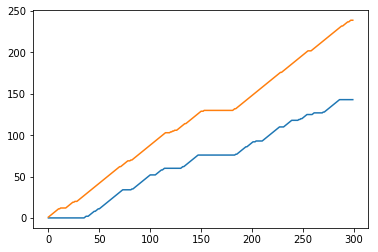

In [32]:
plt.plot(np.cumsum(direct_loc[390:690]));
plt.plot(np.cumsum(mnv_loc[390:690]));